### Calculate MIG for each model iteration

In [43]:
# imports
import os
import sys
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.compat.v1 import gfile
import pdb
import pickle

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # CPU-only

sys.path.append(os.path.abspath("/home/mwu34/disentanglement_lib"))
import numpy as np
np.set_printoptions(precision=3, suppress=True)

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm

from scipy.stats import spearmanr

In [26]:
# def index_to_factors(index_array, factor_bases, save=False):
#     """transform dataset image indices to factors."""
#     factor_bases = factor_bases.astype(int)
#     factors = np.zeros((len(index_array), len(factor_bases) - 1))
#     for factor_idx, factor_base in enumerate(factor_bases[1:]):
#         factors[:, factor_idx], index_array = np.divmod(index_array, factor_base)
    
#     if save:
#         save_path = os.path.join(
#             os.environ.get("DISENTANGLEMENT_LIB_DATA", "."),
#             "dsprites", f"{selection_criterion}.pickle"
#         )
#         informative_points = {
#             'informative_indices': index_array,
#             'informative_factors': factors
#         }
#         with open(save_path, 'wb') as handle:
#             pickle.dump(informative_points, handle, protocol=pickle.HIGHEST_PROTOCOL)
#         print(f'saved informative points to {save_path}')
#     else:
#         print('no save_path specified, not saving informative points')
    
#     return factors

In [44]:
# retrieve the representation associated with the dataset
def retrieve_representation(dataset, module_path, num_random_points, random=False):
    with hub.eval_function_for_module(module_path) as f:
        def _gaussian_encoder(x):
            """Encodes images using trained model."""
            # Push images through the TFHub module.
            output = f(dict(images=x), signature="gaussian_encoder", as_dict=True)
            # Convert to numpy arrays and return.
            return {key: np.array(values) for key, values in output.items()}
        if random:
            select_indices = random_state.choice(len(dataset.images), num_random_points, replace=False)
            images = np.expand_dims(dataset.images[select_indices], 3)
            representation_dict = _gaussian_encoder(images)
            
        else:  # retrieve representation of the entire dataset
            num_points_per_block = 10000
            num_blocks = int(np.ceil(len(dataset.images) / num_points_per_block))
            representation_list = [0] * num_blocks
            for block in range(num_blocks):
                start_idx = num_points_per_block * block
                images = np.expand_dims(dataset.images[start_idx: start_idx + num_points_per_block], 3)
                representation_list[block] = _gaussian_encoder(images)
            representation_dict = dict()
            print(representation_list[0].keys())
            for key in representation_list[0].keys():
                representation_dict[key] = np.concatenate([block[key] for block in representation_list], axis=0)
            
        representation_dict['std'] = np.exp(representation_dict['logvar'] / 2)
        representation_dict['kl'] = (
            representation_dict['mean'] ** 2
            + representation_dict['std'] ** 2
            - representation_dict['logvar'] - 1
        ) / 2
        return representation_dict

In [6]:
from disentanglement_lib.evaluation.metrics.utils import discrete_mutual_info, discrete_entropy


def histogram_discretizer(target, num_bins):
    """Discretization based on histograms."""

    discretized = np.zeros_like(target)
    for i in range(target.shape[0]):
        discretized[i, :] = np.digitize(
            target[i, :],
            np.histogram(target[i, :], num_bins)[1][:-1]
        )
    return discretized

def compute_mig(mus_train, ys_train, num_bins):
    """Computes score based on both training and testing codes and factors."""
    score_dict = {}
    discretized_mus = histogram_discretizer(mus_train, num_bins)
    m = discrete_mutual_info(discretized_mus, ys_train)
    assert m.shape[0] == mus_train.shape[0]
    assert m.shape[1] == ys_train.shape[0]
    # m is [num_latents, num_factors]
    entropy = discrete_entropy(ys_train)
    sorted_m = np.sort(m, axis=0)[::-1]
    if sorted_m.shape[0] == 1:
        per_fov_mig = np.divide(np.zeros(sorted_m[0, :].shape), entropy[:])
    else:
        per_fov_mig = np.divide(sorted_m[0, :] - sorted_m[1, :], entropy[:])
    
    score_dict["per_fov_mig"] = per_fov_mig
    score_dict["discrete_mig"] = np.mean(per_fov_mig)
    score_dict["mi_matrix"] = m
    return score_dict

In [4]:
# get the original dsprites dataset
from disentanglement_lib.data.ground_truth import named_data
dsprites = named_data.get_named_ground_truth_data('dsprites_full', -1)

In [22]:
smallnorb = named_data.get_named_ground_truth_data('smallnorb', 0)

In [46]:
mpi3d = named_data.get_named_ground_truth_data('mpi3d_toy', 0)

In [103]:
# for a model, retrieve dropout mean and uncertainty 
model_artifact_dir = "/home/mwu34/disentanglement_lib/output_active_learning_study_v10/10/model/artifacts/"
labelled_indices = []
dropout_mean = []
num_iterations = 9
num_latent = 10
dataset = dsprites


for iteration in range(10):
    file_path = os.path.join(model_artifact_dir, f"labelled_indices_iter_{iteration}.npy")
    indices = np.load(file_path)
    labelled_indices.extend(list(indices))
    if iteration > 0:
        mean_file_path = os.path.join(model_artifact_dir, f"dropout_mean_iter_{iteration}.npy")
        mus = np.load(mean_file_path)
        dropout_mean.append(mus)
        
labelled_factors = index_to_factors(labelled_indices, dataset.factor_bases, save=False)

no save_path specified, not saving informative points


In [45]:
def calculate_disentanglement_metric_for_all_iterations(
    dataset,
    num_training_points,
    num_bins,
    num_iterations,
    model_artifact_dir,
    save_results=False
):
    mig = np.zeros((1, num_iterations))
    per_fov_mig = np.zeros((dataset.num_factors, num_iterations))
    # use same set of indices for all mig calculation
    random_indices = np.random.choice(len(dataset.images), num_training_points, replace=False)
    factors_train = dataset.index_to_factors(random_indices).T

    for iteration in range(1, num_iterations + 1):
        mean_file_path = os.path.join(model_artifact_dir, f"dropout_mean_iter_{iteration}.npy")
        mus = np.load(mean_file_path)
        mus_train = mus[random_indices, :].T
        mig_results = compute_mig(mus_train, factors_train, num_bins)
        mig[0, iteration - 1] = mig_results['discrete_mig']
        per_fov_mig[:, iteration - 1] = mig_results['per_fov_mig']
    print(f"mig each iter is: \n{mig}")
    print(f"mig per fov is \n{per_fov_mig}")
    if save_results:
        results_path = os.path.join(model_artifact_dir, "mig_results.npy")
        np.save(results_path, mig)
    return mig
    

In [49]:
num_training_points = 10000
num_bins = 20
num_iterations = 10
exp_idx = 11
dataset = mpi3d

for model_idx in range(30, 45):
    model_artifact_dir = os.path.join(
        "/home/mwu34/disentanglement_lib/",
        f"output_active_learning_study_v{exp_idx}/{model_idx}/model/artifacts/"
    )
    print(f'calculating mig at model_idx: {model_idx}')
    mig = calculate_disentanglement_metric_for_all_iterations(
        dataset,
        num_training_points,
        num_bins,
        num_iterations,
        model_artifact_dir,
        save_results=False
    )


calculating mig at model_idx: 30
mig each iter is: 
[[0.211 0.238 0.298 0.329 0.323 0.363 0.384 0.399 0.413 0.415]]
mig per fov is 
[[0.105 0.148 0.209 0.285 0.345 0.398 0.49  0.492 0.519 0.576]
 [0.003 0.001 0.002 0.007 0.003 0.004 0.005 0.007 0.002 0.004]
 [0.002 0.011 0.021 0.025 0.038 0.052 0.062 0.068 0.078 0.086]
 [0.757 0.606 0.82  0.876 0.756 0.893 0.892 0.876 0.91  0.851]
 [0.505 0.72  0.775 0.814 0.799 0.814 0.814 0.893 0.872 0.865]
 [0.059 0.079 0.094 0.112 0.119 0.154 0.18  0.207 0.231 0.235]
 [0.047 0.099 0.164 0.186 0.199 0.226 0.244 0.25  0.278 0.288]]
calculating mig at model_idx: 31
mig each iter is: 
[[0.22  0.254 0.269 0.294 0.32  0.337 0.37  0.374 0.385 0.402]]
mig per fov is 
[[0.12  0.154 0.197 0.222 0.297 0.334 0.431 0.469 0.565 0.584]
 [0.    0.002 0.    0.005 0.001 0.    0.    0.01  0.001 0.008]
 [0.004 0.008 0.016 0.034 0.04  0.041 0.059 0.059 0.077 0.081]
 [0.785 0.833 0.68  0.784 0.827 0.802 0.855 0.872 0.775 0.867]
 [0.534 0.606 0.735 0.724 0.784 0.811 0.84

In [56]:
# correlation between fovs and latent units
dataset = mpi3d
random_indices = np.random.choice(len(dataset.images), num_training_points, replace=False)


for model_idx in range(30, 45):
    model_artifact_dir = os.path.join(
        "/home/mwu34/disentanglement_lib/",
        f"output_active_learning_study_v{exp_idx}/{model_idx}/model/artifacts/"
    )
    factors_train = dataset.index_to_factors(random_indices).T
    mean_file_path = os.path.join(model_artifact_dir, f"dropout_mean_iter_10.npy")
    mus = np.load(mean_file_path)
    mus_train = mus[random_indices].T
    correlation = np.corrcoef(np.concatenate((factors_train, mus_train), axis=0))
    x_correlation = correlation[:dataset.num_factors, dataset.num_factors:]
    np.fill_diagonal(x_correlation, 0)
    print(f"at model {model_idx}")
    print(x_correlation)
    print(np.sum(np.abs(x_correlation)))
    
    

at model 30
[[ 0.    -0.247 -0.12  -0.032 -0.007  0.028 -0.001 -0.103  0.059  0.031]
 [-0.017  0.     0.057  0.018 -0.004 -0.022  0.009 -0.049  0.029 -0.018]
 [-0.012  0.142  0.     0.006 -0.013 -0.049 -0.008 -0.187  0.021  0.064]
 [ 0.021  0.029  0.067  0.     0.043  0.031 -0.011  0.065  0.152  0.008]
 [ 0.035  0.059  0.031  0.027  0.    -0.001  0.02  -0.113  0.37   0.391]
 [ 0.015 -0.062 -0.116 -0.003 -0.002  0.    -0.013  0.044  0.125  0.023]
 [ 0.009  0.    -0.004 -0.032  0.017  0.041  0.     0.238  0.053 -0.231]]
3.848505368943689
at model 31
[[ 0.    -0.232 -0.218 -0.055 -0.004 -0.042  0.026  0.032  0.014  0.003]
 [-0.02   0.     0.061  0.023 -0.007 -0.002  0.007 -0.02   0.01   0.021]
 [ 0.009  0.098  0.     0.012 -0.019 -0.019  0.001 -0.074  0.016  0.098]
 [ 0.01   0.032  0.136  0.     0.029  0.026 -0.065 -0.358  0.025  0.061]
 [ 0.019  0.069  0.1    0.027  0.     0.006  0.008  0.196  0.457  0.047]
 [-0.003 -0.14  -0.107 -0.024 -0.012  0.    -0.01   0.004  0.08  -0.003]
 [-0.004

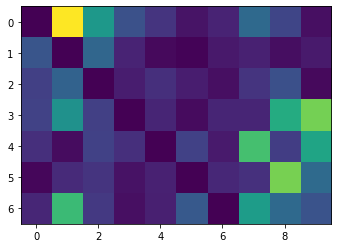

In [58]:
plt.imshow(np.abs(x_correlation))

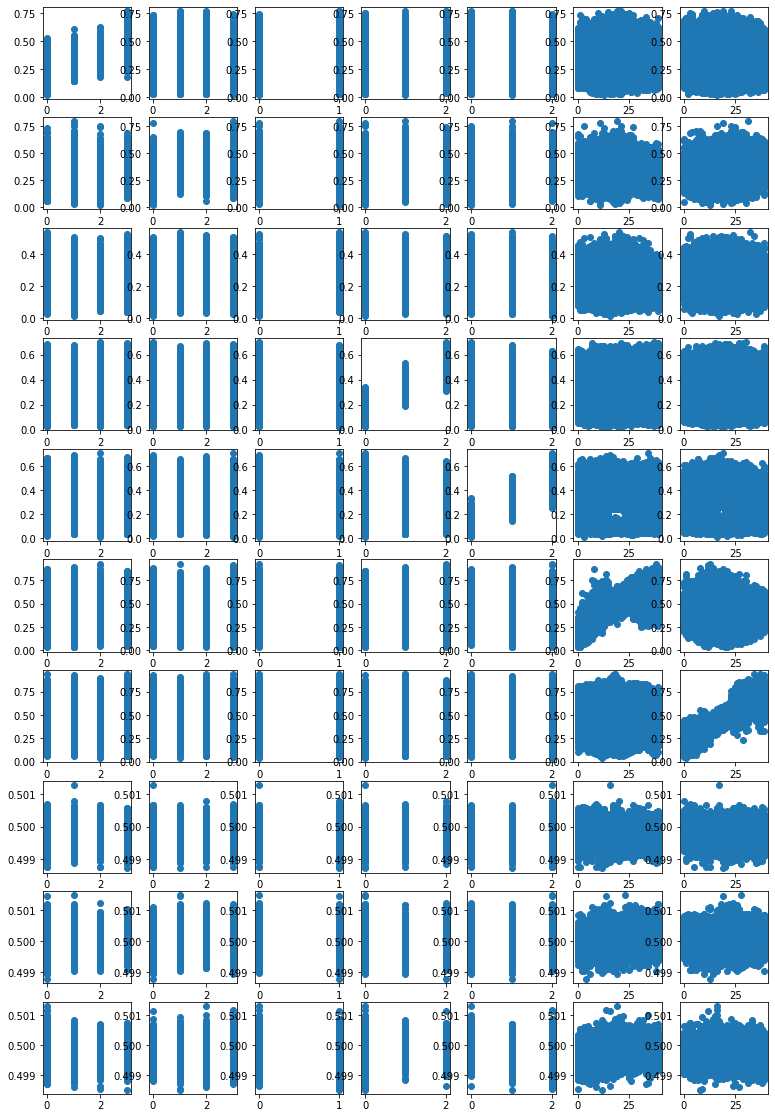

In [52]:
# visualize correlation between fovs and latent units
num_latents = mus_train.shape[0]
num_fovs = factors_train.shape[0]

fig, axs = plt.subplots(num_latents, num_fovs, figsize=(13, 20))
for latent in range(num_latents):
    for fov in range(num_fovs):
        ax = axs[latent][fov]
        ax.scatter(factors_train[fov, :], 1/(1 + np.exp(-mus_train[latent, :])))


In [53]:
dataset.factors_num_values

[4, 4, 2, 3, 3, 40, 40]